In [10]:
import numpy as np
import torch
import cryo_em_sbi
import matplotlib.pyplot as plt

In [117]:
model = torch.tensor(np.load("../models/hsp90_models.npy")[0, 0])

config = {
    "IMAGES": {"N_PIXELS": 128, "PIXEL_SIZE": 1.0, "SIGMA": 2.0},
    "SIMULATION": {
        "N_SIMULATIONS": 100,
        "MODEL_FILE": "../../models/hsp90_models.npy",
        "DEVICE": "cpu",
        "ROTATIONS": "QUAT_576",
    },
    "PREPROCESSING": {
        "SHIFT": True,
        "CTF": True,
        "NOISE": True,
        "DEFOCUS": 1.5,
        "SNR": 0.1,
    },
    "TRAINING": {
        "MODEL": "maf",
        "HIDDEN_FEATURES": 100,
        "NUM_TRANSFORMS": 4,
        "DEVICE": "cpu",
        "BATCH_SIZE": 1000,
        "POSTERIOR_NAME": "posterior_all_effects_noise_01.pkl",
    },
}

In [44]:
def gen_img(coord, image_params, dtype):

    n_atoms = coord.shape[1]
    norm = 1 / (2 * torch.pi * image_params["SIGMA"] ** 2 * n_atoms)

    grid_min = -image_params["PIXEL_SIZE"] * (image_params["N_PIXELS"] - 1) * 0.5
    grid_max = (
        image_params["PIXEL_SIZE"] * (image_params["N_PIXELS"] - 1) * 0.5
        + image_params["PIXEL_SIZE"]
    )

    grid = torch.arange(grid_min, grid_max, image_params["PIXEL_SIZE"], dtype=dtype)
    gauss_x = torch.zeros((image_params["N_PIXELS"], n_atoms), dtype=dtype)
    gauss_y = torch.zeros((image_params["N_PIXELS"], n_atoms), dtype=dtype)

    gauss_x[:, :] = torch.exp(
        -0.5 * (((grid[:, None] - coord[0, :]) / image_params["SIGMA"]) ** 2)
    )

    gauss_y[:, :] = torch.exp(
        -0.5 * (((grid[:, None] - coord[1, :]) / image_params["SIGMA"]) ** 2)
    )

    image = torch.matmul(gauss_x, gauss_y.T) * norm

    return image

In [80]:
def apply_ctf(image, image_params, preproc_params):
    def calc_ctf(n_pixels, amp, phase, b_factor):

        ctf = torch.zeros((n_pixels, n_pixels), dtype=torch.complex64)

        freq_pix_1d = torch.fft.fftfreq(n_pixels, d=image_params["PIXEL_SIZE"])

        x, y = torch.meshgrid(freq_pix_1d, freq_pix_1d)

        freq2_2d = x**2 + y**2
        imag = torch.zeros_like(freq2_2d) * 1j

        env = torch.exp(-b_factor * freq2_2d * 0.5)
        ctf = (
            amp * torch.cos(phase * freq2_2d * 0.5)
            - np.sqrt(1 - amp**2) * torch.sin(phase * freq2_2d * 0.5)
            + imag
        )

        return ctf * env / amp

    b_factor = 0.0  # no
    amp = 0.1  # no

    elecwavel = 0.019866
    phase = preproc_params["DEFOCUS"] * torch.pi * 2.0 * 10000 * elecwavel

    ctf = calc_ctf(image.shape[0], amp, phase, b_factor)

    conv_image_ctf = torch.fft.fft2(image) * ctf

    image_ctf = torch.fft.ifft2(conv_image_ctf).real

    return image_ctf

In [134]:
def add_noise(img, preproc_params):

    mean_image = torch.mean(img)
    std_image = torch.std(img)

    mask = torch.logical_or(
        img >= mean_image + 0.5 * std_image, img <= mean_image - 0.5 * std_image
    )

    signal_std = torch.std(img[mask])

    noise_mean = torch.mean(img[mask])
    noise_std = signal_std / np.sqrt(preproc_params["SNR"])

    print("Old Method: ", noise_std)

    noise = torch.normal(mean=noise_mean, std=noise_std, size=img.shape)

    img_noise = img + noise

    return img_noise

In [140]:
def circular_mask(n_pixels, radius):

    grid = torch.linspace(-0.5 * (n_pixels - 1), 0.5 * (n_pixels - 1), n_pixels)
    r_2d = grid[None, :] ** 2 + grid[:, None] ** 2
    mask = r_2d < radius**2

    return mask


def add_noise_torch_batch(img, snr):

    n_pixels = img.shape[1]
    radius = n_pixels * 0.4
    mask = circular_mask(n_pixels, radius)
    image_noise = torch.empty_like(img, device="cpu")

    for i, image in enumerate(img):

        image_masked = image[mask]
        signal_std = image_masked.pow(2).mean().sqrt()
        noise_std = signal_std / np.sqrt(snr)
        noise = torch.distributions.normal.Normal(0, noise_std).sample(image.shape)
        image_noise[i] = image + noise

    return image_noise

In [165]:
def add_noise_new(img, preproc_params, radius_coef):

    mask = circular_mask(n_pixels=img.shape[0], radius=img.shape[0] * radius_coef)

    signal_std = img[mask].pow(2).mean().sqrt()
    noise_std = signal_std / np.sqrt(preproc_params["SNR"])

    img_noise = img + torch.distributions.normal.Normal(0, noise_std).sample(img.shape)

    print("New Method: ", noise_std)
    # return noise_std
    return img_noise

In [152]:
rad = np.linspace(0.1, 0.9, 100)
noises = np.zeros_like(rad)

for i in range(rad.shape[0]):

    noises[i] = add_noise_new(ctf_img_db, config["PREPROCESSING"], rad[i])

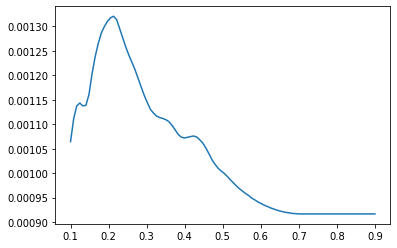

In [153]:
plt.plot(rad, noises)

In [95]:
img_db = gen_img(model, config["IMAGES"], torch.float64)
img_ft = gen_img(model, config["IMAGES"], torch.float32)

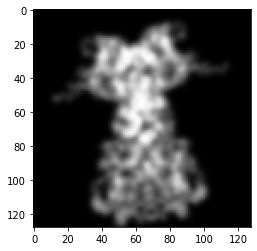

In [96]:
plt.imshow(img_db.numpy(), cmap="Greys_r")

In [97]:
ctf_img_db = apply_ctf(img_db, config["IMAGES"], config["PREPROCESSING"])

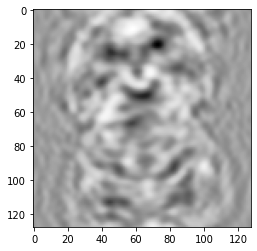

In [98]:
plt.imshow(ctf_img_db.numpy(), cmap="Greys_r")

In [166]:
noise_ctf_img_db = add_noise(ctf_img_db, config["PREPROCESSING"])
noise_ctf_img_db1 = add_noise_new(ctf_img_db, config["PREPROCESSING"], 0.4)
noise_ctf_img_db2 = add_noise_new(ctf_img_db, config["PREPROCESSING"], 1.0)

Old Method:  tensor(0.0013, dtype=torch.float64)
New Method:  tensor(0.0011, dtype=torch.float64)
New Method:  tensor(0.0009, dtype=torch.float64)


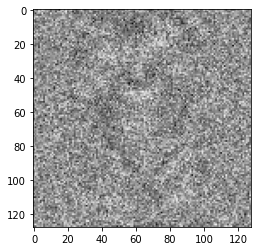

In [163]:
plt.imshow(noise_ctf_img_db1.numpy(), cmap="Greys")

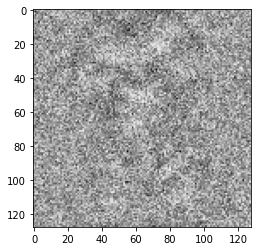

In [164]:
plt.imshow(noise_ctf_img_db2.numpy(), cmap="Greys")